In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import beam.calc.electron as ecalc
import scipy.constants as const
from beam.beams import electronbeam
from beam import interactions
plt.style.use('notes')
me = const.physical_constants['electron mass energy equivalent in MeV'][0]
e = const.physical_constants['elementary charge'][0]
path = 'Data/'

In [2]:
# Setup the parameters for simulation
Nz = 2000
z = np.linspace(0, 100*2*np.pi, Nz, dtype='double')
gb0 = 20000
ne0 = 2*gb0/5.95074e4**2 # Go from Robert units to normalized units
ne = ne0*np.ones(Nz)
kb = 5.95074e4 * np.sqrt(ne0)/np.sqrt(2*gb0)
betaBeam = 1
alphaBeam = 0
eps = 1.0e-6
delta = 0.02
sigma_r0 = np.sqrt(betaBeam*eps)
electronParams = {
    'name' : 'No_Offset',
    'path' : path,
    'load' : False,
    'N' : 50000,
    'gamma' : 20000,
    'emittance' : gb0*eps,
    'betax' : betaBeam,
    'betay' : betaBeam,
    'alphax' : alphaBeam,
    'alphay' : alphaBeam,
    'sigmaz' : 5e-6,
    'dE' : delta
}

class plasmaCls():
    def __init__(self):
        """ Empy init function """
    def get_ne(self, z):
        return ne
    def dgammadz(self, ne):
        return 0.0
    
plasmaDen = plasmaCls()
dumpPer = 10

In [3]:
# Second moment for a offset matched beam
dumpPer = 1
offset = 1.0
electronParams['offset_y'] = 0
electronParams['offset_xp'] = 0
electronParams['offset_yp'] = 0
electronParams['offset_x'] = offset*sigma_r0
electronParams['name'] = 'x-%0.2fsigmar0_Emittance' % (offset)
beam = electronbeam.OffsetGaussianElectronBeam(electronParams)
interactions.electron_plasma(beam, plasmaDen, z*1e6, dumpPer, 4)
beam_CS = beam.get_CS()
ptcls = beam.load_ptcls(int(Nz/dumpPer)-1)[0]

In [29]:
ptcls = beam.load_ptcls(0)[0]
x = beam.get_x(ptcls)
xp = beam.get_xp(ptcls)
syyp = np.average(x*xp)

z_plot = np.linspace(0, 100*2*np.pi, 10000)
sy2 = sigma_r0**2*(1  + offset**2)
gammaBeam = (1+alphaBeam**2)/betaBeam
syp2 = gammaBeam*eps
DeltaY = offset*sigma_r0
#DeltaY = offset
Psimax = z_plot/(np.sqrt(1-delta))
Psimin = z_plot/(np.sqrt(1+delta))
DeltaPsi = (Psimax-Psimin)

y02 = (0.5*(sy2+syp2)+0.5*(syyp*2*np.sin(Psimax+Psimin)+(sy2-syp2)*np.cos(Psimax+Psimin))
         *np.sinc(DeltaPsi/np.pi))
yp02 = (0.5*(sy2+syp2)-0.5*(syyp*2*np.sin(Psimax+Psimin)+(sy2-syp2)*np.cos(Psimax+Psimin))
         *np.sinc(DeltaPsi/np.pi))
yyp0 = (0.5*(syyp*2*np.cos(Psimax+Psimin)-(sy2-syp2)*np.sin(Psimax+Psimin))
         *np.sinc(DeltaPsi/np.pi))
y0 = np.sinc(DeltaPsi/2/np.pi)*np.cos((Psimax+Psimin)/2)*offset*sigma_r0
yp0 = -np.sinc(DeltaPsi/2/np.pi)*np.sin((Psimax+Psimin)/2)*offset*sigma_r0

sy02 = y02 - y0**2
syp02 = yp02 - yp0**2
syyp = yyp0 - y0*yp0
emt = np.sqrt(sy02*syp02 - syyp**2)

emt = 0.5*np.sqrt((sy2+syp2)**2-np.sinc(DeltaPsi/np.pi)**2*((syp2-sy2)**2+4*syyp**2)-2*np.sinc(DeltaPsi/2/np.pi)**2
                 *((sy2+syp2)*DeltaY**2+np.sinc(DeltaPsi/np.pi)*(syp2-sy2)*DeltaY**2))
emt = eps*0.5*(2+DeltaY**2/eps)*np.sqrt(1-np.sinc(DeltaPsi/np.pi)**2*DeltaY**4/(2*eps+DeltaY**2)**2
                                -2*np.sinc(DeltaPsi/2/np.pi)**2*(DeltaY**2/(2*eps+DeltaY**2)
                                                                 -np.sinc(DeltaPsi/np.pi)
                                                                 *DeltaY**4/(2*eps+DeltaY**2)**2))

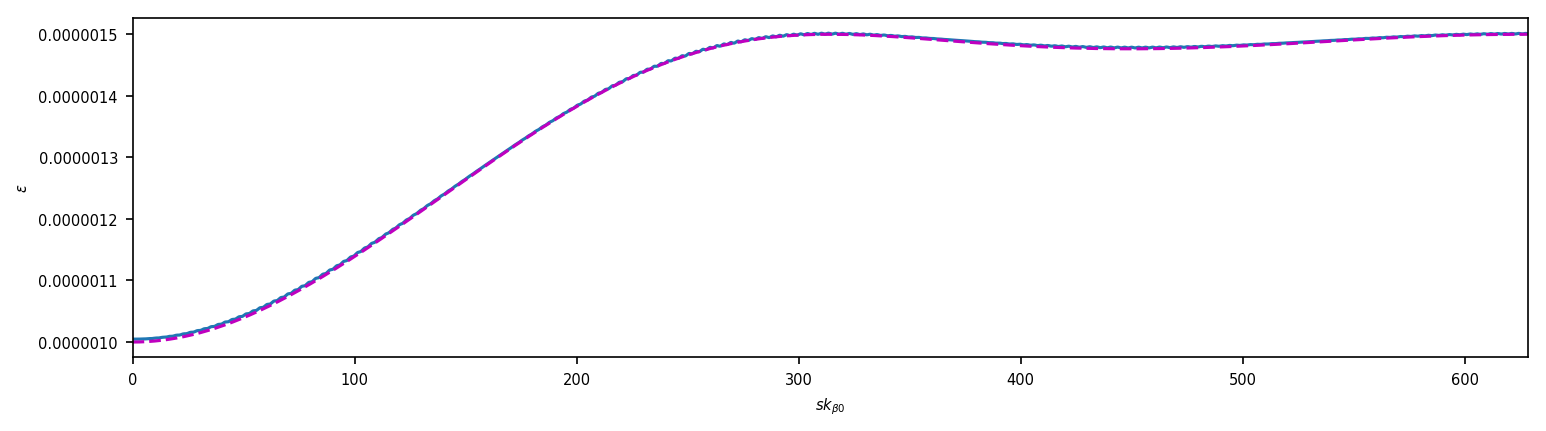

In [30]:
plt.figure(figsize=(12, 3), dpi=150)
plt.plot(beam.z, beam_CS['eps_x'])
plt.plot(z_plot, emt, 'm--')
plt.xlabel(r'$sk_{\beta0}$')
plt.ylabel(r'$\epsilon$')
plt.xlim(0, 100*2*np.pi)
plt.show()